### Note: Possibility of improvements over the choices of p(t), a0, c0

This notebook aims to showcase Ising solvers running simulated bifurcation.

References:
1. https://advances.sciencemag.org/content/5/4/eaav2372
2. https://advances.sciencemag.org/content/7/6/eabe7953

In [1]:
import numpy as np
import numba as nb
import time
import matplotlib.pyplot as plt

In [ ]:
def no_local(Q):
    """
    Return a matrix of shape (N+1, M+1) with no local field.
    See S1 in supplementary materials for sciadv.abe7953 for more details.
    """
    new_Q = np.zeros((Q.shape[0]+1, Q.shape[1]+1))
    new_Q[:-1, :-1] = Q - np.diag(np.diag(Q))
    new_Q[:-1, -1] = np.diag(Q)
    return new_Q

In [2]:
#@nb.njit(parallel=False)
def one_aSB_run(Q_matrix, steps, dt, Kerr_coef, a0, c0, init_y):
    """
    One (adiabatic) simulated bifurcation run over the full pump schedule.
    
    Parameters:
        Q_matrix (2-D array of float): The matrix representing the coupling field of the problem.
        steps (int): The number of iterations.
        dt (float): Time step for the discretized time.
        Kerr_coef (float): The Kerr coefficient.
        a0, c0 (float): Positive constants.
        init_y (1-D array of float): Initial y.
    
    Return: final_state (1-D array of float)
    """
    
    local_flg = False
    if np.diag(Q_matrix).any():
        Q = no_local(Q)
        local_flg = True
    
    #np.random.seed(sd)
    
    N = Q_matrix.shape[0]
    x = flt(np.zeros(N))
    y = flt(init_y)
    
    for k in range(steps):
        x += a0 * y * dt
        y -= (Kerr_coef * x**3 + a0 * (1. - k/steps) * x - c0 * Q_matrix.dot(x)) * dt
        #x_history[k] = x # for analysis purposes
    
    if local_flg:
        return np.sign(x[:-1]) * np.sign(x[-1])
    else:
        return np.sign(x)

In [3]:
Q = np.array([[0., 1.], [1., 0.]])
n = 2000
dt = 200/n
a0 = 0.5
c0 = 0.3
PS = [a0/n * i for i in range(n)]

In [4]:
# Without numba
x_history = np.zeros((n, 2))
start_time = time.time()
ans = one_aSB_run(Q, PS, dt, 1., a0, c0)
total_time = time.time() - start_time
print(f'ground state: {ans}; time: {total_time} s')

ground state: [-1. -1.]; time: 0.037024736404418945 s


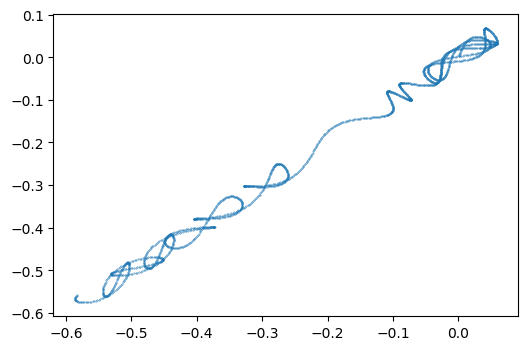

In [5]:
plt.figure(dpi=100)
plt.scatter(x_history[:, 0], x_history[:, 1], s=.1)

In [6]:
#@nb.njit(parallel=False)
def one_bSB_run(Q_matrix, steps, dt, a0, c0, init_y):
    """
    One ballistic simulated bifurcation run over the full pump schedule.
    
    Parameters:
        Q_matrix (2-D array of float): The matrix representing the local and coupling field of the problem.
        steps (int): The number of iterations.
        dt (float): Time step for the discretized time.
        a0, c0 (float): Positive constants.
        init_y (1-D array of float): Initial y.
    
    Return: final_state (1-D array of float)
    """
    
    local_flg = False
    if np.diag(Q_matrix).any():
        Q = no_local(Q)
        local_flg = True
    
    #np.random.seed(sd)
    
    N = Q_matrix.shape[0]
    x = flt(np.zeros(N))
    y = flt(init_y)
    
    for k in range(steps):
        x += a0 * y * dt
        y -= (a0 * (1. - k/steps) * x - c0 * Q_matrix.dot(x)) * dt # pump increases from 0 to a0 linearly
        for i in range(N): # parallelizable
            if np.abs(x[i]) > 1:
                x[i] = np.sign(x[i])
                y[i] = 0
        #x_history[k] = x # for analysis purposes
    
    if local_flg:
        return np.sign(x[:-1]) * np.sign(x[-1])
    else:
        return np.sign(x)

In [7]:
# Without numba
x_history = np.zeros((n, 2))
start_time = time.time()
ans = one_bSB_run(Q, n, dt, a0, c0)
total_time = time.time() - start_time
print(f'ground state: {ans}; time: {total_time} s')

ground state: [-1. -1.]; time: 0.06502366065979004 s


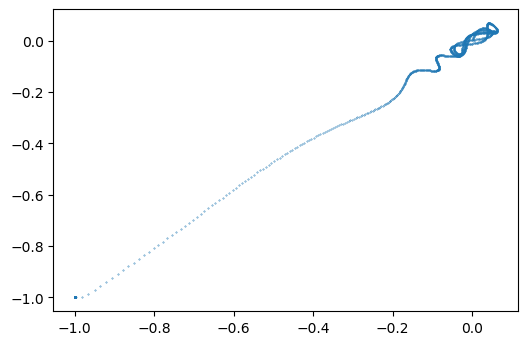

In [8]:
plt.figure(dpi=100)
plt.scatter(x_history[:, 0], x_history[:, 1], s=.1)

In [9]:
#@nb.njit(parallel=False)
def one_dSB_run(Q_matrix, steps, dt, a0, c0, init_y):
    """
    One discrete simulated bifurcation run over the full pump schedule.
    
    Parameters:
        Q_matrix (2-D array of float): The matrix representing the local and coupling field of the problem.
        steps (int): The number of iterations.
        dt (float): Time step for the discretized time.
        a0, c0 (float): Positive constants.
        init_y (1-D array of float): Initial y.
    
    Return: final_state (1-D array of float)
    """
    
    local_flg = False
    if np.diag(Q_matrix).any():
        Q = no_local(Q)
        local_flg = True
    
    #np.random.seed(sd)
    
    N = Q_matrix.shape[0]
    x = flt(np.zeros(N))
    y = flt(init_y)
    
    for k in range(steps):
        x += a0 * y * dt
        y -= (a0 * (1. - k/steps) * x - c0 * Q_matrix.dot(np.sign(x))) * dt
        for i in range(N): # parallelizable
            if np.abs(x[i]) > 1:
                x[i] = np.sign(x[i])
                y[i] = 0
        #x_history[k] = x # for analysis purposes
    
    if local_flg:
        return np.sign(x[:-1]) * np.sign(x[-1])
    else:
        return np.sign(x)

In [10]:
# Without numba
x_history = np.zeros((n, 2))
start_time = time.time()
ans = one_dSB_run(Q, n, dt, a0, c0)
total_time = time.time() - start_time
print(f'ground state: {ans}; time: {total_time} s')

ground state: [1. 1.]; time: 0.05405735969543457 s


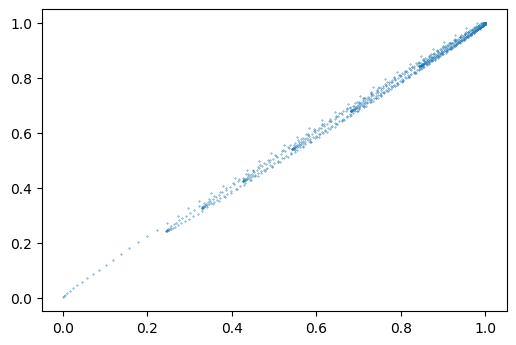

In [11]:
plt.figure(dpi=100)
plt.scatter(x_history[:, 0], x_history[:, 1], s=.1)